# Artificial Intelligence Nanodegree
## Machine Translation Project
In this notebook, sections that end with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully!

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [1]:
%load_ext autoreload
%aimport helper, tests
%autoreload 1

In [2]:
import collections

import helper
import numpy as np
import project_tests as tests

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

/app/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Verify access to the GPU
The following test applies only if you expect to be using a GPU, e.g., while running in a Udacity Workspace or using an AWS instance with GPU support. Run the next cell, and verify that the device_type is "GPU".
- If the device is not GPU & you are running from a Udacity Workspace, then save your workspace with the icon at the top, then click "enable" at the bottom of the workspace.
- If the device is not GPU & you are running from an AWS instance, then refer to the cloud computing instructions in the classroom to verify your setup steps.

In [3]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [4]:

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="3"; 

## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [5]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


### Files
Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file.

In [6]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


From looking at the sentences, you can see they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.
### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

In [7]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


For comparison, _Alice's Adventures in Wonderland_ contains 2,766 unique words of a total of 15,500 words.
## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

Time to start preprocessing the data...
### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.

Running the cell will run `tokenize` on sample data and show output for debugging.

In [8]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    x_tk = Tokenizer(num_words=None,
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                     lower=True,
                     split=' ',
                     char_level=False)
    x_tk.fit_on_texts(x)

    return x_tk.texts_to_sequences(x), x_tk

tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding (IMPLEMENTATION)
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [9]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    if length:
        maximum_length = length
    else:
        maximum_length = max([len(l) for l in x])
    padded_sequences = pad_sequences(x,
                                     maxlen=maximum_length,
                                     dtype='int32',
                                     padding='post',
                                     truncating='post',
                                     value=0.0)
    return padded_sequences

tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline.  Instead, we've provided you with the implementation of the `preprocess` function.

In [10]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


## Models
In this section, you will experiment with various neural network architectures.
You will begin by training four relatively simple architectures.
- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding
- Model 3 is a Bidirectional RNN
- Model 4 is an optional Encoder-Decoder RNN

After experimenting with the four simple architectures, you will construct a deeper architecture that is designed to outperform all four models.
### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [11]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    # it seems logits are otput from the model after softmax with shape = (number of prediction, vocabulary_size)
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')


def index_to_text(sentence, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    # it seems logits are otput from the model after softmax with shape = (number of prediction, vocabulary_size)
    return ' '.join([index_to_words[ind[0]] for ind in sentence])




`logits_to_text` function loaded.


# Index Word Dictionary
example of index_to_words = {0: '<PAD>', 1: 'the', 2: 'quick', 3: 'a', 4: 'brown', 5: 'fox', 6: 'jumps', 7: 'over', 8: 'lazy', 9: 'dog', 10: 'by', 11: 'jove', 12: 'my', 13: 'study', 14: 'of', 15: 'lexicography', 16: 'won', 17: 'prize', 18: 'this', 19: 'is', 20: 'short', 21: 'sentence'}

### Model 1: RNN (IMPLEMENTATION)
![RNN](images/rnn.png)
A basic RNN model is a good baseline for sequence data.  In this model, you'll build a RNN that translates English to French.

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [13]:
from keras import Sequential
from keras.layers import LSTM 


def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 1e-3
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape[1:]))
    model.add(Dense(french_vocab_size, activation='softmax'))
    
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    

    return model

# tests.test_simple_model(simple_model)

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)



simple_rnn_model.summary()
    
simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=1, validation_split=0.2)

# Print prediction(s)
print("predicted  :", logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))
print("groundtruth:", index_to_text(preproc_french_sentences[:1][0], french_tokenizer))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 21, 64)            16896     
_________________________________________________________________
dense_1 (Dense)              (None, 21, 344)           22360     
Total params: 39,256
Trainable params: 39,256
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27573 samples
Epoch 1/1
110288/110288 [==============================] - 16s 141us/step - loss: 3.5473 - acc: 0.4024 - val_loss: nan - val_acc: 0.4576
predicted  : en est est est en est en est est <PAD> en <PAD> en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
groundtruth: new jersey est parfois calme pendant l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


### Model 2: Embedding (IMPLEMENTATION)
![RNN](images/embedding.png)
You've turned the words into ids, but there's a better representation of a word.  This is called word embeddings.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In this model, you'll create a RNN model using embedding.

In [14]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-3       
    
    model = Sequential()
    model.add(
          Embedding(
          input_dim = english_vocab_size,
          output_dim = 64,
          input_length = input_shape[1],
          trainable= True))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dense(french_vocab_size, activation='softmax'))
     
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    

    return model

# tests.test_embed_model(embed_model)


tmp_x_padded = pad(preproc_english_sentences, max_french_sequence_length)
# tmp_x_reshaped = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
embed_rnn_model = embed_model(
    tmp_x_padded.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)



embed_rnn_model.summary()
    
embed_rnn_model.fit(tmp_x_padded, preproc_french_sentences, batch_size=1024, epochs=1, validation_split=0.2)

# Print prediction(s)
print("predicted  :", logits_to_text(embed_rnn_model.predict(tmp_x_padded[1:2])[0], french_tokenizer))
print("groundtruth:", index_to_text(preproc_french_sentences[1:2][0], french_tokenizer))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 64)            12736     
_________________________________________________________________
lstm_2 (LSTM)                (None, 21, 64)            33024     
_________________________________________________________________
dense_2 (Dense)              (None, 21, 344)           22360     
Total params: 68,120
Trainable params: 68,120
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27573 samples
Epoch 1/1
110288/110288 [==============================] - 5s 47us/step - loss: 3.8108 - acc: 0.4007 - val_loss: nan - val_acc: 0.4093
predicted  : <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
groundtruth: les états unis est généralement froid en juillet et il gèle habi

### Model 3: Bidirectional RNNs (IMPLEMENTATION)
![RNN](images/bidirectional.png)
One restriction of a RNN is that it can't see the future input, only the past.  This is where bidirectional recurrent neural networks come in.  They are able to see the future data.

In [15]:
from keras.layers import Bidirectional

def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-3    
    
    
    # model form 1
    model = Sequential()
    model.add(
          Embedding(input_dim = english_vocab_size,
          output_dim = 64,
          input_length = input_shape[1],
          trainable= True))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dense(french_vocab_size, activation='softmax'))
    

    
    # model form 2
#     input_seq = Input(shape=input_shape[1:])
#     embedded_seq = Embedding(input_dim = english_vocab_size, 
#                              output_dim = 64,
#                              input_length=input_shape[1])(input_seq)
    
#     rnn = Bidirectional(units=100, return_sequences=True)(embedded_seq)
#     logits = TimeDistributed(Dense(units=french_vocab_size))(rnn) 
#     model = Model(input_seq, Activation('softmax')(logits))    
    
    
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    

    return model

# tests.test_embed_model(embed_model)


tmp_x_padded = pad(preproc_english_sentences, max_french_sequence_length)
# tmp_x_reshaped = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
bd_rnn_model = bd_model(
    tmp_x_padded.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)



bd_rnn_model.summary()
    
bd_rnn_model.fit(tmp_x_padded, preproc_french_sentences, batch_size=1024, epochs=1, validation_split=0.2)

# Print prediction(s)
print("predicted  :", logits_to_text(bd_rnn_model.predict(tmp_x_padded[1:2])[0], french_tokenizer))
print("groundtruth:", index_to_text(preproc_french_sentences[1:2][0], french_tokenizer))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 21, 64)            12736     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 128)           66048     
_________________________________________________________________
dense_3 (Dense)              (None, 21, 344)           44376     
Total params: 123,160
Trainable params: 123,160
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27573 samples
Epoch 1/1
110288/110288 [==============================] - 9s 79us/step - loss: 3.3879 - acc: 0.4367 - val_loss: nan - val_acc: 0.4762
predicted  : est est est est est est est est est est est est est <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
groundtruth: les états unis est généralement froid en juillet et il gèle habituellement en novembre <

### Model 4: Encoder-Decoder (OPTIONAL)
Time to look at encoder-decoder models.  This model is made up of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.

Create an encoder-decoder model in the cell below.

# Keras Tutorials Seq2Sqe Model 1

In [27]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

def seq2seq_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """

    latent_dim = 10
    num_encoder_tokens = input_shape
    num_decoder_tokens = 10 
    learning_rate = 1e-3
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=input_shape)
    encoder = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, num_decoder_tokens))
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    
    return model
# tests.test_encdec_model(encdec_model)


tmp_x_padded = pad(preproc_english_sentences, max_french_sequence_length)
# tmp_x_reshaped = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
seq2seq_rnn_model = seq2seq_model(
    tmp_x_padded.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)



seq2seq_rnn_model.summary()
    
# seq2seq_rnn_model.fit(tmp_x_padded, preproc_french_sentences, batch_size=1024, epochs=1, validation_split=0.2)


# model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#       batch_size=batch_size,
#       epochs=epochs,
#       validation_split=0.2)

# OPTIONAL: Train and Print prediction(s)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 137861, 21)   0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, None, 10)     0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, 10), (None,  1280        input_8[0][0]                    
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, None, 10), ( 840         input_9[0][0]                    
                                                                 lstm_10[0][1]                    
          

# Amir Seq2Seq Model 1

In [ ]:
model = Sequential()
model.add(
      Embedding(input_dim = english_vocab_size,
      output_dim = 64,
      input_length = input_shape[1],
      trainable= True))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dense(french_vocab_size, activation='softmax'))

# Keras Seq2Seq model 2

In [36]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'data/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')[:2]
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        # notice there is one matrix for each time step, and you can have maximum of 1 character in each time step
        # that is in each time step we decided to use 1 hot endocing to represent each character
        # number of time steps = lenght of words in the sentence
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

        
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')



Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 18s 2ms/step - loss: 1.1974 - acc: 0.7238 - val_loss: 1.0698 - val_acc: 0.6996
Epoch 2/50
8000/8000 [==============================] - 14s 2ms/step - loss: 0.8719 - acc: 0.7631 - val_loss: 0.8761 - val_acc: 0.7568
Epoch 3/50
8000/8000 [==============================] - 14s 2ms/step - loss: 0.6959 - acc: 0.8044 - val_loss: 0.7291 - val_acc: 0.7901
Epoch 4/50
8000/8000 [==============================] - 14s 2ms/step - loss: 0.5970 - acc: 0.8263 - val_loss: 0.6588 - val_acc: 0.8076
Epoch 5/50
8000/8000 [==============================] - 14s 2ms/step - loss: 0.5471 - acc: 0.8399 - val_loss: 0.6162 - val_acc: 0.8202
Epoch 6/50
8000/8000 [==============================] - 14s 2ms/step - loss: 0.5099 - acc: 0.8501 - val_loss: 0.

/app/local/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_10 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_9/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_9/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


# Model Inferences

In [37]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        # it seems we do not have to ever go beyond t = 1 (time step 1)
        # because we are recording and carrying h and c from each step to the next manually
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Run!
Decoded sentence: Parsons !

-
Input sentence: Run!
Decoded sentence: Parsons !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Chant !

-
Input sentence: Fire!
Decoded sentence: Chénies !

-
Input sentence: Help!
Decoded sentence: Aise-nous !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Atteffinu !

-
Input sentence: Stop!
Decoded sentence: Atteffinu !

-
Input sentence: Stop!
Decoded sentence: Atteffinu !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Hello!
Decoded sentence: Salut !

-
Input sente

# Creating Document Embedding

In [40]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
import numpy as np
np.random.seed(0)  # Set a random seed for reproducibility

# Headline input: meant to receive sequences of 100 integers, each integer between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
main_input = Input(shape=(100,), dtype='int32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=512, input_dim=10000, input_length=100)(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)

model = Model(inputs=main_input, outputs=lstm_out)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 100, 512)          5120000   
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                69760     
Total params: 5,189,760
Trainable params: 5,189,760
Non-trainable params: 0
_________________________________________________________________


# Simple encoder-decoder 

The first alternative model is to generate the entire output sequence in a one-shot manner.

That is, the decoder uses the context vector alone to generate the output sequence.
Alternate 1 - One-Shot Text Summarization Model



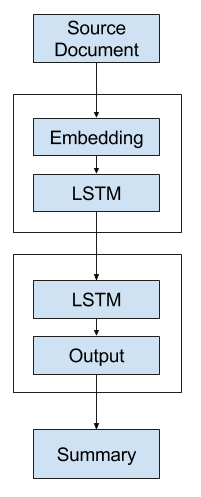

In [44]:
from IPython.display import Image
Image("images/Alternate-1-One-Shot-Text-Summarization-Model.png")

In [39]:
# the same exact copy of encoder final state is the input to the decoder. 
# inputs are of shape (bathc size, 
#                      sequence of indexes: the length of sequence = src_txt_length
#                                         : each element of is an index of word, index = {0, .... 2999} due to vocab size)

src_txt_length = 10
sum_txt_length = 12
vocab_size = 3000
# encoder input model
inputs = Input(shape=(src_txt_length,))
encoder1 = Embedding(vocab_size, 128)(inputs)
encoder2 = LSTM(128)(encoder1)  # we only get the last output from LSTM , so the length is (batch , 128)
encoder3 = RepeatVector(sum_txt_length)(encoder2)  # creates identical copies of LSTM layer , how many ? sum_txt_length times, each of these are seperately pass as input to the decoder.
# decoder output model
decoder1 = LSTM(128, return_sequences=True)(encoder3)
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder1)
# tie it together
model = Model(inputs=inputs, outputs=outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 10)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 10, 128)           384000    
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               131584    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 12, 128)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 12, 128)           131584    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 12, 3000)          387000    
Total params: 1,034,168
Trainable params: 1,034,168
Non-trainable params: 0
_________________________________________________________________


# Encoder-Decoder 2
A second alternative model is to develop a model that generates a single word forecast and call it recursively.

That is, the decoder uses the context vector and the distributed representation of all words generated so far as input in order to generate the next word.

A language model can be used to interpret the sequence of words generated so far to provide a second context vector to combine with the representation of the source document in order to generate the next word in the sequence.

The summary is built up by recursively calling the model with the previously generated word appended (or, more specifically, the expected previous word during training).

The context vectors could be concentrated or added together to provide a broader context for the decoder to interpret and output the next word.
Alternate 2 - Recursive Text Summarization Model A



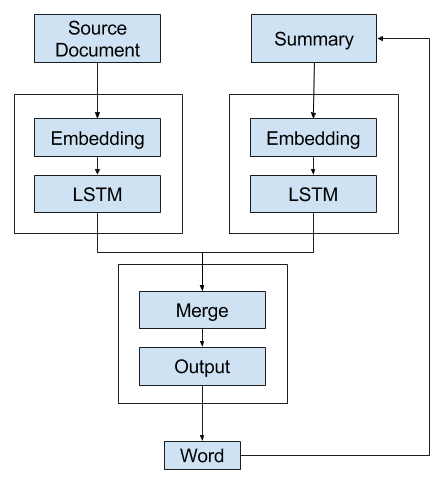

In [43]:
from IPython.display import Image
Image("images/Alternate-2-Recursive-Text-Summarization-Model-A.png")

# personal notes to myself
i think the way we build this model is to start by outputs sequence then
we add ['start translating'] token index to the begining of "outputs" sequence
and dropping the last element of outputs sequence.
calling the resulting seruqnce inputs2. This way inputs2 is always 1 step behind outputs and missing its
final element. 
i do not know if we train complete sequences at once or feed them one at a time
during prediction we have to call the model for every new ouput word generated
notice only a single word is predicted from the model.
so at any time step we feed to it the input + output upto what we have seen so far (initial output = 'start translating')
then expect it to spit out the next output, which we add to the first ouput and feed it again for 2nd prediction


In [48]:
from keras.layers import concatenate

src_txt_length = 10
sum_txt_length = 20
# source text input model
inputs1 = Input(shape=(src_txt_length,))
am1 = Embedding(vocab_size, 128)(inputs1)
am2 = LSTM(128)(am1)
# summary input model
inputs2 = Input(shape=(sum_txt_length,))
sm1 = Embedding(vocab_size, 128)(inputs2)
sm2 = LSTM(128)(sm1)
# decoder output model
decoder1 = concatenate([am2, sm2])
# notice only a single word is predicted from the model.
# so at any time step we feed to it the input + output upto what we have seen so far (initial output = 'start translating')
# then expect it to spit out the next output, which we add to the first ouput and feed it again for 2nd prediction
outputs = Dense(vocab_size, activation='softmax')(decoder1)  
# tie it together [article, summary] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 10, 128)      384000      input_18[0][0]                   
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 20, 128)      384000      input_19[0][0]                   
__________________________________________________________________________________________________
lstm_26 (L

# Encoder-Decoder 3
In this third alternative, the Encoder generates a context vector representation of the source document.

This document is fed to the decoder at each step of the generated output sequence. This allows the decoder to build up the same internal state as was used to generate the words in the output sequence so that it is primed to generate the next word in the sequence.

This process is then repeated by calling the model again and again for each word in the output sequence until a maximum length or end-of-sequence token is generated.

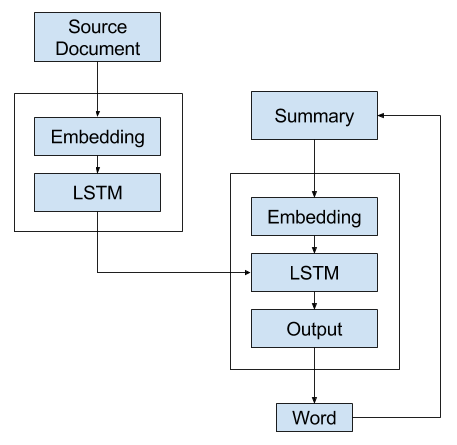

In [49]:
from IPython.display import Image
Image("images/Alternate-3-Recursive-Text-Summarization-Model-B.png")

In [51]:
vocab_size = 3000
src_txt_length = 10
sum_txt_length = 20
# article input model
inputs1 = Input(shape=(src_txt_length,))
article1 = Embedding(vocab_size, 128)(inputs1)
article2 = LSTM(128)(article1)
article3 = RepeatVector(sum_txt_length)(article2)
# summary input model
inputs2 = Input(shape=(sum_txt_length,))
summ1 = Embedding(vocab_size, 128)(inputs2)
# decoder model
decoder1 = concatenate([article3, summ1])
decoder2 = LSTM(128)(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
# tie it together [article, summary] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 10, 128)      384000      input_22[0][0]                   
__________________________________________________________________________________________________
lstm_30 (LSTM)                  (None, 128)          131584      embedding_17[0][0]               
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
repeat_vec

# Encoder Decore 4

In [52]:
vocab_size = 3000
context_size = 128   # Example: 128
src_txt_length = 10
sum_txt_length = 20
# article input model
inputs1 = Input(shape=(src_txt_length,))
article1 = Embedding(vocab_size, context_size)(inputs1)
article2, state_h, state_c  = LSTM(context_size,
                                   return_state=True)(article1)
states = [ state_h, state_c ]
# summary input model
inputs2 = Input(shape=(sum_txt_length,))
summ1 = Embedding(vocab_size, context_size)(inputs2)
# decoder model
decoder1 = LSTM(context_size,
                return_sequences=True)(summ1, initial_state=states)
outputs = Dense(vocab_size, activation='softmax')(decoder1)
# tie it together [article, summary] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 10, 128)      384000      input_24[0][0]                   
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 20, 128)      384000      input_25[0][0]                   
__________________________________________________________________________________________________
lstm_32 (L

### Model 5: Custom (IMPLEMENTATION)
Use everything you learned from the previous models to create a model that incorporates embedding and a bidirectional rnn into one model.

In [ ]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    return None
tests.test_model_final(model_final)


print('Final Model Loaded')
# TODO: Train the final model

## Prediction (IMPLEMENTATION)

In [ ]:
def final_predictions(x, y, x_tk, y_tk):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed French data
    :param x_tk: English tokenizer
    :param y_tk: French tokenizer
    """
    # TODO: Train neural network using model_final
    model = embed_rnn_model

    
    ## DON'T EDIT ANYTHING BELOW THIS LINE
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'he saw a old yellow truck'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))

    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))


final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)

## Submission
When you're ready to submit, complete the following steps:
1. Review the [rubric](https://review.udacity.com/#!/rubrics/1004/view) to ensure your submission meets all requirements to pass
2. Generate an HTML version of this notebook

  - Run the next cell to attempt automatic generation (this is the recommended method in Workspaces)
  - Navigate to **FILE -> Download as -> HTML (.html)**
  - Manually generate a copy using `nbconvert` from your shell terminal
```
$ pip install nbconvert
$ python -m nbconvert machine_translation.ipynb
```
  
3. Submit the project

  - If you are in a Workspace, simply click the "Submit Project" button (bottom towards the right)
  
  - Otherwise, add the following files into a zip archive and submit them 
  - `helper.py`
  - `machine_translation.ipynb`
  - `machine_translation.html`
    - You can export the notebook by navigating to **File -> Download as -> HTML (.html)**.

### Generate the html

**Save your notebook before running the next cell to generate the HTML output.** Then submit your project.

In [ ]:
# Save before you run this cell!
!!jupyter nbconvert *.ipynb

## Optional Enhancements

This project focuses on learning various network architectures for machine translation, but we don't evaluate the models according to best practices by splitting the data into separate test & training sets -- so the model accuracy is overstated. Use the [`sklearn.model_selection.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to create separate training & test datasets, then retrain each of the models using only the training set and evaluate the prediction accuracy using the hold out test set. Does the "best" model change?